# **Montecarlo**
----

## Goals of this notebook:

1. Make sure that the most basic environment (HitStand) properly works.
2. Deploy main plotting utilities.
3. Execute a simple experiment to make sure that my hand-made Montecarlo-based algorithms (for both prediction and control) are mistake proof.
4. Define methods to accelerate multiple episode executions in later notebooks.
5. Showcase agents' common efficiency-oriented capabilities (e.g.: Q/V-table storage and agent storage).

---
## Library imports

#### 1. RL libraries:

In [1]:
import environments
from agents.agents import MonteCarloPredictor, MontecarloController, OffPolicyMontecarlo

#### 2. Data aggregation and matrix operation libraries:

In [2]:
import numpy as np
import pandas as pd

#### 3. Plotting libraries:

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter, FuncFormatter
import seaborn as sns
# Commands to tweak notebook layout:
from sys import maxsize
np.set_printoptions(threshold=maxsize)
plt.style.use('seaborn-pastel')

----

## Common plotting utilities:

#### Average reward time series:

In [4]:
def plot_reward_time_series(X,Y, far=True):
    """
    X: a range of numbers starting from the sample size number to the total number of episode + 1
       (to make it inclusive) and incrementing by sample size steps.
    Y: average rewards
    far: bool. If False the plots zooms in.
    
    returns: the plot container instance
    """
    # domain redefinition to adjust how many x-ticks are displayed dinamically
    max_domain = X[-1]
    multiplier = len(str(max_domain)) - 2
    step = int(str(max_domain)[0]) * 10**multiplier
    domain = np.arange(X[0], max_domain + step, step)
    
    if far:
        ylim = (-1, 1)
        yticks= np.round(np.arange(-1,1.05,0.05), 2)
    else:
        max_value = max(0, max(Y))
        ylim = (min(Y), max_value)
        yticks = np.round(np.arange(min(Y)-0.1, max_value + 0.1, 0.01), 2)
    
    fig = plt.figure(figsize=(20,10))
    
    style_dict = {'xlim': (X[0], max_domain),
                  'xticks': domain,
                  'xticklabels': domain,
                  'xlabel': 'Episodes',
                  'ylim': ylim,
                  'yticks': yticks,
                  'yticklabels': yticks,
                  'title': 'Average reward over last {0:,.0f} episodes'.format(X[0])
                 }
    
    ax = fig.add_subplot(1,1,1, **style_dict)
    ax.grid()
    #Axis formatters:
    formatter = ScalarFormatter(useMathText=True)
    #Scientific value display when the total number of episodes is over 1M:
    formatter.set_scientific(True)
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.2f'))
    # in and out of the money border:
    ax.plot(domain.ravel(), np.zeros_like(domain).ravel(), color='red')
    
    ax.plot(X,Y)
    return ax

#### Density plot:

In [5]:
def plot_density(data):
    """
    data: a Panda Series containing every sample of average rewards
    
    returns: both histogram and boxplot container instances
    """
    title = 'Average reward sampling: $\overline{{X}}$={0:.2f}, s={1:.2f}, n={2:,.0f}, num of samples={3:,.0f}'\
            .format(data.mean(),
                    data.std(),
                    data.index.values[0],
                    len(data))
    
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(20,10), gridspec_kw={"height_ratios": (.15, .85)}) 
    fig.suptitle(t=title, fontsize=16, x=0.5, y=1.05)
    
    sns.boxplot(data=data,x=data, ax=ax_box)
    sns.histplot(data=data, x=data, ax=ax_hist, bins=20, kde=True)
    
    #Delimiting tails:
    ax_hist.axvline(x=np.percentile(data,[2.5]), label='2.5th percentile', c='r')
    ax_hist.axvline(x=np.percentile(data,[97.5]), label='97.5th percentile', c='r')
    ax_hist.legend()
    ax_hist.set_xlabel('Average Reward')
    
    return ax_box, ax_hist

#### Value Function:

In [6]:
def plot_v_func(table, title):
    """
    table: agent's V-table (if agents has a Q-table, that must be transformed before being passed as an argument for this function)
    title: str. A title for the plot
    
    returns: the plot container instance
    """
    X = np.linspace(1,10,10)
    Y = np.linspace(12, 20,9)
    Xm, Ym = np.meshgrid(X, Y)
    
    fig = plt.figure(figsize=(20,10))
    fig.suptitle(t=title, fontsize=16, x=0.5, y=1.05)
    
    common_style_dict = {'xlim': (X[0], X[-1]),
                        'xticks': X,
                        'xticklabels': ['{:.0f}'.format(value) for value in list(X)[1:]] + ['A'],
                        'xlabel': 'Dealer\'s Card',
                        'ylim': (Y[0], Y[-1]),
                        'yticks': Y,
                        'yticklabels': Y,
                         'ylabel': 'Player\'s Total',
                        'zlim': (-1, 1.5),
                        'zticks': np.arange(-1, 1.8, 0.2),
                        'zticklabels': np.arange(-1, 1.8, 0.2),
                        }
    
    #Not usable ace-related states:
    ax = fig.add_subplot(1,2,1, projection='3d', title='No usable Ace', **common_style_dict)
    surface_1 = ax.plot_surface(Xm, Ym, table[8:17,:10,0], cmap=plt.get_cmap('bwr'), vmin=-1, vmax=1)
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.0f'))
    ax.zaxis.set_major_formatter(FormatStrFormatter('% 1.1f'))
    ax.view_init(ax.elev, -120)
    
    #Usable ace-related states:
    ax = fig.add_subplot(1,2,2, projection='3d', title=' Usable Ace', **common_style_dict)
    surface_2 = ax.plot_surface(Xm, Ym, table[8:17,:10,1], cmap=plt.get_cmap('bwr'), vmin=-1, vmax=1)
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.0f'))
    ax.zaxis.set_major_formatter(FormatStrFormatter('% 1.1f'))
    ax.view_init(ax.elev, -120)
    
    #Colour bar:
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.35, 0.01, 0.5])
    fig.colorbar(surface_1,shrink=0.2, aspect=15, cax=cbar_ax)
    
    return ax

#### Policy:

In [7]:
def plot_policy(table, title):
    """
    table: matrix containing action indexes (it must have n-1 dimensions with respect to the agent's Q-table)
    title: str. A title for the plot
    
    returns: the plot container instance
    """
    #tick label transformer (used for the colour bar):
    def format_tick(x, pos):
        if x == 0:
            return '{0}-STAND'.format(str(x))
        elif x == 1:
            return '{0}-HIT'.format(str(x))
    
    X = np.arange(-.5,9.5,1)
    Y = np.arange(0.5, 11.5,1)
    
    fig = plt.figure(figsize=(20,10))
    fig.suptitle(t=title, fontsize=16, x=0.5, y=1.05)
    
    common_style_dict = {'xlim': (-.5, 9.5),
                        'xticks': X,
                        'xticklabels': ['{:.0f}'.format(value) for value in range(2,11,1)] + ['A'],
                        'xlabel': 'Dealer\'s Card',
                        'yticks': Y,
                        'yticklabels': np.arange(11,22,1),
                        'ylabel': 'Player\'s Total'
                        }
    #I only plot those states wherein there is risk of going bust after hitting once more and, for the sake of symmetry,
    #I manually modify those non-existing usable-ace-related states:
    table[:8,:,1] = 1
    
    #Not usable ace-related states:
    ax = fig.add_subplot(1,2,1, title='No usable Ace', **common_style_dict)
    im = ax.imshow(table[7:18,:10,0], cmap=plt.get_cmap('bwr'), vmin=0, vmax=1, alpha=0.5)
    ax.invert_yaxis()
    ax.grid(True,color='w', linestyle='-', linewidth=1, axis='both')
    ##Little tweak for tick labels' position:
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('left')

    for label in ax.get_yticklabels():
        label.set_verticalalignment('top')
    
    #Usable ace-related states:
    ax = fig.add_subplot(1,2,2, title=' Usable Ace', **common_style_dict)
    ax.imshow(table[7:18,:10,1],cmap=plt.get_cmap('bwr'), vmin=0, vmax=1, alpha=0.5)
    ax.invert_yaxis()
    ax.grid(True,color='w', linestyle='-', linewidth=1, axis='both')
    ##Little tweak for tick labels' position:
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('left')
    
    #Colour bar definition
    fig.subplots_adjust(right=0.8)
    original_cmap = plt.get_cmap('bwr')
    
    #Converting a multiple-colour cmap into 2-colour cmap
    cmap = ListedColormap([original_cmap(0), original_cmap(original_cmap.N)])
    bounds = [0, 0.5, 1]
    norm = BoundaryNorm(bounds, original_cmap.N)    
    cbar_ax = fig.add_axes([0.85, 0.05, 0.01, 0.85])
    
    fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),
                 shrink=0.2,
                 aspect=15,
                 cax=cbar_ax,
                 boundaries= [0] + bounds + [2],  
                 extend='both',
                 ticks=[0,1],
                 format = FuncFormatter(format_tick),
                 spacing='proportional',
                 orientation='vertical',
                 alpha= 0.5)
    
    return ax

----

## Basic enviroment presentation:

In [8]:
# AI gym-like enviroment instance creation:
env = environments.make('hitstand')

In [9]:
print(env)
# Main rules:

1. 6 decks (with replacement after each episode)
2. Dealer stands on soft 17
3. No Double Down
4. No split
5. No insurance offered
6. No surrender
7. Natural Blackjack 3:2


**Code note**: although natural Blackjack triggers a 3:2 payoff, it will never be computed as Blackjack states entail automatic state transition (the agent receives two cards and just needs to wait for hand resolution). Unlike AI gym, hitting 21 also triggers automatic state transition to a terminal state; it does not make sense to evaluate which action is best when there is no room for choosing in real life Blackjack.

In [10]:
# player's name is Jack always:
env.reward_space_description

{-1: 'The House beats Jack',
 0: 'Draw/not terminal',
 1: 'Jack beats the House',
 1.5: 'Blackjack for Jack'}

In [11]:
env.observation_space_description
# Every observation consists of a 3-element tuple, the description for each element and their positions are:

{0: "Player's total", 1: "Dealer's card value", 2: 'Player has got usable ace'}

A "usable ace" means the ace value is 11, instead of 1.

In [12]:
'Observation space ranges from {0} to {1}'.format(env.observation_space_low, env.observation_space_high)

'Observation space ranges from [4 2 0] to [30 26  1]'

**Comments on the observation space definition**:

- Lower bounds: Player's total value is bounded from below at 4, as any potential smaller value would imply the use of an ace (and its value is 11 at the start of the hand); Dealer's is bounded from below at 2, as he/she is only handed out one card initially.

- Upper bounds: those reach the maximum value a player/dealer might obtain. However, any state that goes over 21 is not computationally taken into account; they are terminal states and final reward is associated to both the last executed action and the state from which transition to terminal state is taking place. Therefore, the Q/V-table values for terminal states remain 0 over the whole experiments.

- Player has got usable ace: a binary encoding is used to indicate whether or not the player has got a usable ace (0=False, 1=True).

----

## Experiment Definition:
The following method allows playing a given number of episodes of a given RL environment with a given RL agent:

In [13]:
def run_experiment(environment, agent, episodes, show, save=None, collect_rewards=None, train=True):
    """
    env: instance of the environment to execute.
    agent: instance of the agent that will interact with the environment.
    show: integer. It indicates how often episodes are printed as text(it helps track the existence of bugs in the game itself).
    save: integer. It indicates how often the V/Q-table is permanently persisted as a pickle object. None = no persistence at all.
    collect_rewards: It indicates every so many episodes rewards are averaged. 1 = return every reward.
    train: bool. If True, the agent learns by updating its V/Q-table; if False, the agent just executes a defined policy.
    
    returns: a list containing all average rewards computed throughout the whole experiment.
    """
    rewards = []
    average_rewards = []
    for episode in range(episodes):
        if (episode+1) % show ==0:
            print('Episode {0}:'.format(episode+1))
            env.render()

        state, reward, terminal, _ = env.reset()
        while not terminal:
            action = agent.follow_policy(state)
            next_state, reward, terminal, _ = env.step(action)
            if train:
                agent.evaluate_state(state, reward, terminal, action)   
                
            state=next_state
            
        rewards.append(reward)
        
        if save:
            if (episode+1) % save == 0:
                agent.save_table()
                
        if collect_rewards:
            if (episode+1) % collect_rewards == 0:
                average_reward = sum(rewards[-collect_rewards:])/collect_rewards
                average_rewards.append(average_reward)
    
    return average_rewards

---

## Agent Deployments

### 1. Montecarlo Prediction:

The goal is to learn $V_\pi$ from episodes of experience under policy $\pi$. The value of a state is not updated until the end of the episode (offline), since the whole reward sequence is necessary to push the estimated value to its true value.

I use **every visit** Montecarlo. For the problem at hand, there is no difference between first visit and every visit MC, because the likelihood to visit the same state in the same episode is 0%: the agent only retains the same value after obtaining a combination of ace and a card between 2 and 9, then hitting and receiving a 10-point card. However, that sequence of states triggers a transition from a usable-ace state to a non-usable-ace state.

The algorithm implementation is as follows:

<img src='interfaces/web/static/img/Montecarlo_prediction.png'>

Where the return is the total discounted reward:

$$G_t = R_{t+1} +  \gamma R_{t+2} + ... + \gamma^{T-1}R_T$$

And the V-function at any state is the expected return:

$$V_\pi(s) = \mathbb{E}_\pi[G_t |S_t=s]$$

**Code note**: agent classes must be subclassed before instantiation, so that the not implemented "follow_policy" method is overriden. This is the idea I have come up with to define policies for a given agent, what in turn enforces a 'one-agent-one policy' strategy.

In [14]:
class Deterministic(MonteCarloPredictor):
    #V-table is initialized full of 0s
    def follow_policy(self, observation, *args):
        #if your cards add up to a number greater than 17, stand; otherwise, hit:
        if observation[0] > 17:
            return 0
        else:
            return 1

In [15]:
deterministic_agent = Deterministic(env)
# Environment instance is passed as an argument; it helps define a proper size for V/Q-table based on the environment's features.

In [16]:
deterministic_agent.hyperparams
# The agent has the following default parameters:

{'discount_rate': 1, 'learning_rate': None, 'max_episodes': None}

**Code note**:
If **learning rate** value is set to None, it means that the learning rate is defined as $\frac{1}{t}$ (where $t$ is the number of times a state has been visited). It is the default way to push the average towards its true value incrementally and it satisfies the Robbins-Monro conditions for convergence in finite time:

$$\sum_{t=0}^{\infty}\frac{1}{t} = \infty$$
$$\sum_{t=0}^{\infty}\frac{1}{t^2} < \infty$$


#### **First experiment: following a deterministic policy**

In [17]:
EPISODES = 10_000
SHOW_EVERY = 1_000
SAVE_EVERY =  None
#I choose an arbitrary sample size for the purpose of this notebook. I will discuss a more convenient value later (when dealing with train_test splits)
COLLECT_EVERY = 50
results = run_experiment(env, deterministic_agent, EPISODES, SHOW_EVERY, SAVE_EVERY, COLLECT_EVERY)

Episode 1000:
Jack:
	-Cards: ['8C', '4C']
	-Value : 12
Dealer:
	-Cards: ['7D']
	-Value : 7
Jack decides to: HIT
	-Cards: ['8C', '4C', '7C']
	-Value : 19
Jack decides to: STAND
	-Cards: ['8C', '4C', '7C']
	-Value : 19
Dealer:
	-Cards: ['7D', '9S', 'KD']
	-Value : 26
JACK BEATS THE HOUSE
Episode 2000:
Jack:
	-Cards: ['4D', 'AH']
	-Value : 15
Dealer:
	-Cards: ['4D']
	-Value : 4
Jack decides to: HIT
	-Cards: ['4D', 'AH', 'QD']
	-Value : 15
Jack decides to: HIT
	-Cards: ['4D', 'AH', 'QD', 'AH']
	-Value : 16
Jack decides to: HIT
	-Cards: ['4D', 'AH', 'QD', 'AH', 'KH']
	-Value : 26
Dealer:
	-Cards: ['4D']
	-Value : 4
THE HOUSE BEATS JACK
Episode 3000:
Jack:
	-Cards: ['AS', '4D']
	-Value : 15
Dealer:
	-Cards: ['AH']
	-Value : 11
Jack decides to: HIT
	-Cards: ['AS', '4D', '7D']
	-Value : 12
Jack decides to: HIT
	-Cards: ['AS', '4D', '7D', '6H']
	-Value : 18
Jack decides to: STAND
	-Cards: ['AS', '4D', '7D', '6H']
	-Value : 18
Dealer:
	-Cards: ['AH', '4D', '6S']
	-Value : 21
THE HOUSE BEATS JACK

**Average reward** is the main metric I use to measure how well an agent fares when attempting to learn. So it is worth succintly showing some of the tools I am hereafter using to track the metric:

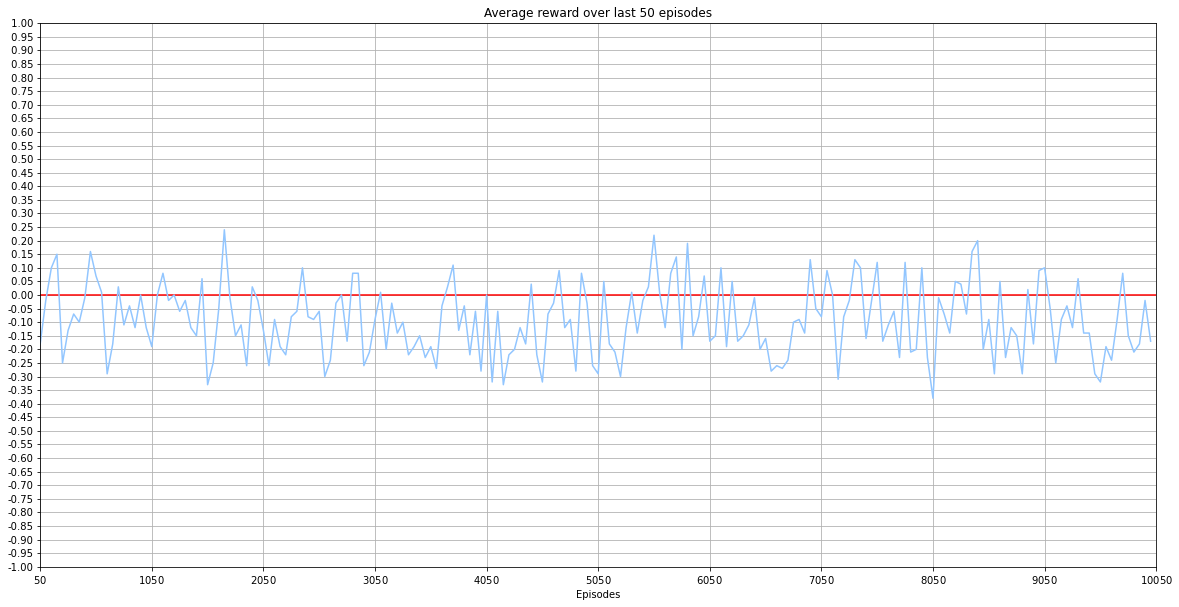

In [18]:
#Calling one of the above-mentioned plotting functions:
plot_reward_time_series(range(COLLECT_EVERY, EPISODES+1, COLLECT_EVERY),results);

#### **Exploring results and Confidence intervals:**

Since card games entail stochasticity (at least, the randomness of withdrawing certain cards from a deck (which implicitly affects the probability of transitioning from one state to another)), it is necessary to set the statistical ground for analysing confidence intervals for average rewards. 

In [19]:
# Short statistical analysis:
runs = pd.Series(data=results, index=range(COLLECT_EVERY, EPISODES+1, COLLECT_EVERY))
runs.describe()

count    200.000000
mean      -0.092300
std        0.131496
min       -0.380000
25%       -0.190000
50%       -0.100000
75%        0.000000
max        0.240000
dtype: float64

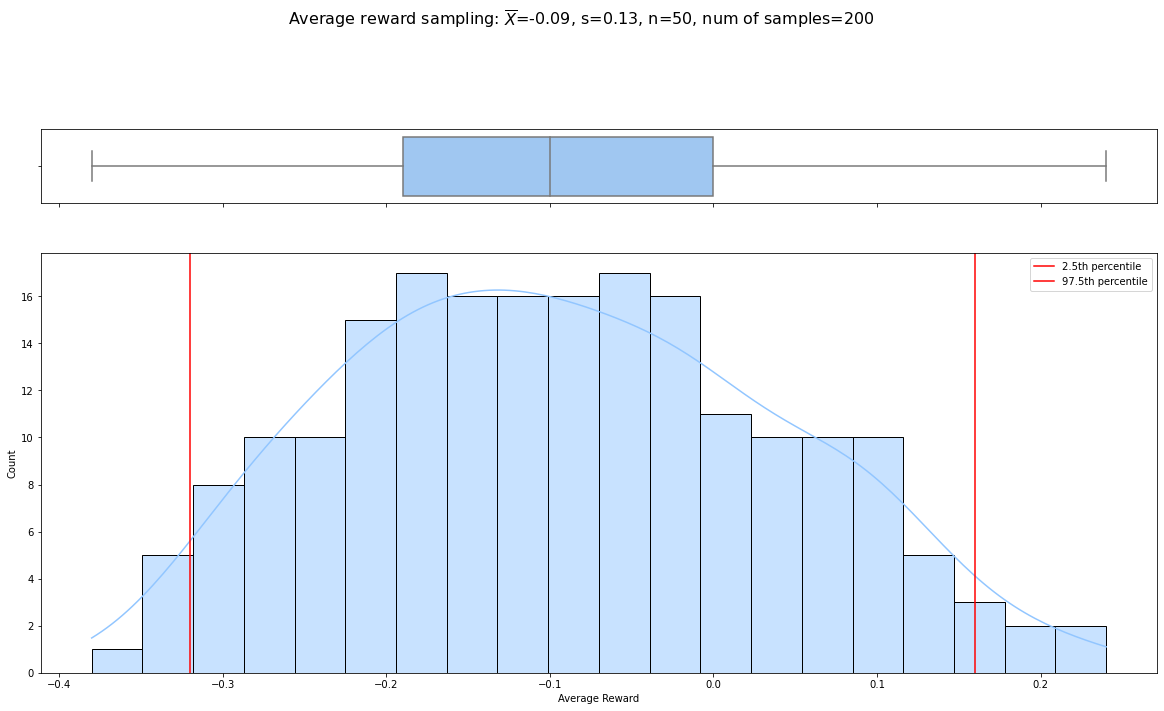

In [20]:
plot_density(runs);

I will later try to seek convergence to a normal distribution by the Law of Large Numbers by increasing the sample size.

On the other hand, it is necessary to evaluate how 'good' falling in a given non-terminal state is. In such case, I proceeed as follows:

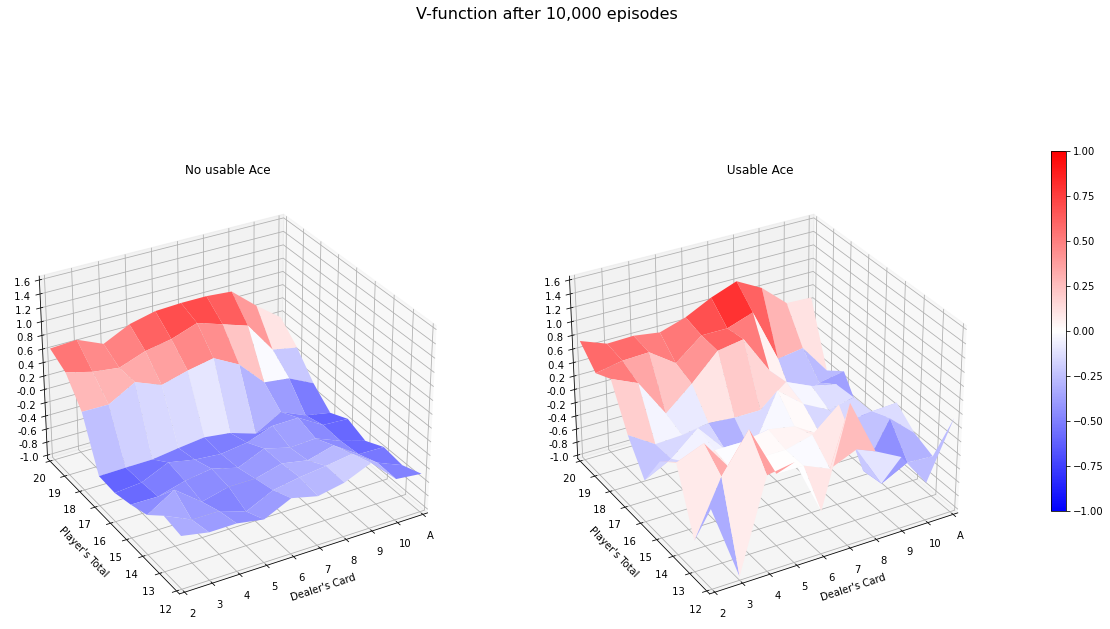

In [21]:
plot_v_func(deterministic_agent.table, 'V-function after {:,.0f} episodes'.format(EPISODES));

#### **Second Experiment: using a stochastic policy**

In [22]:
#Subclassing to furnish a policy for the stochastic agent.
class Stochastic(MonteCarloPredictor):
    
    #MonteCarloPredictor class generates a V-table by default. For this case, it is necessary to use a Q-table: every action can be choosen with a
    #certain probability in every state
    def __init__(self, env, table_type='q'):
        super().__init__(env, table_type)
        
    def follow_policy(self, observation, *args):
        # if my total points add up to a number greater than 15, I choose to stand with prob 0.9 and hit with prob 0.1; otherwise, I choose to hit
        #with prob 0.9 and stand with prob 0.1
        if observation[0] > 15:
            action = np.random.choice((0,1), p=(0.9, 0.1))
        else:
            action = np.random.choice((0,1), p=(0.1,0.9))

        return action


In [23]:
stochastic_agent = Stochastic(env)

In [24]:
EPISODES = 100_000
SHOW_EVERY = 10_000
SAVE_EVERY =  None
COLLECT_EVERY = 50
results = run_experiment(env, stochastic_agent, EPISODES, SHOW_EVERY, SAVE_EVERY, COLLECT_EVERY)

Episode 10000:
Jack:
	-Cards: ['2D', 'JS']
	-Value : 12
Dealer:
	-Cards: ['KC']
	-Value : 10
Jack decides to: HIT
	-Cards: ['2D', 'JS', 'AH']
	-Value : 13
Jack decides to: HIT
	-Cards: ['2D', 'JS', 'AH', '9D']
	-Value : 22
Dealer:
	-Cards: ['KC']
	-Value : 10
THE HOUSE BEATS JACK
Episode 20000:
Jack:
	-Cards: ['3D', '2H']
	-Value : 5
Dealer:
	-Cards: ['9D']
	-Value : 9
Jack decides to: HIT
	-Cards: ['3D', '2H', '6D']
	-Value : 11
Jack decides to: STAND
	-Cards: ['3D', '2H', '6D']
	-Value : 11
Dealer:
	-Cards: ['9D', 'QH']
	-Value : 19
THE HOUSE BEATS JACK
Episode 30000:
Jack:
	-Cards: ['5H', '2C']
	-Value : 7
Dealer:
	-Cards: ['KS']
	-Value : 10
Jack decides to: HIT
	-Cards: ['5H', '2C', '5D']
	-Value : 12
Jack decides to: HIT
	-Cards: ['5H', '2C', '5D', '3D']
	-Value : 15
Jack decides to: HIT
	-Cards: ['5H', '2C', '5D', '3D', '7S']
	-Value : 22
Dealer:
	-Cards: ['KS']
	-Value : 10
THE HOUSE BEATS JACK
Episode 40000:
Jack:
	-Cards: ['AC', '9D']
	-Value : 20
Dealer:
	-Cards: ['10S']
	-V

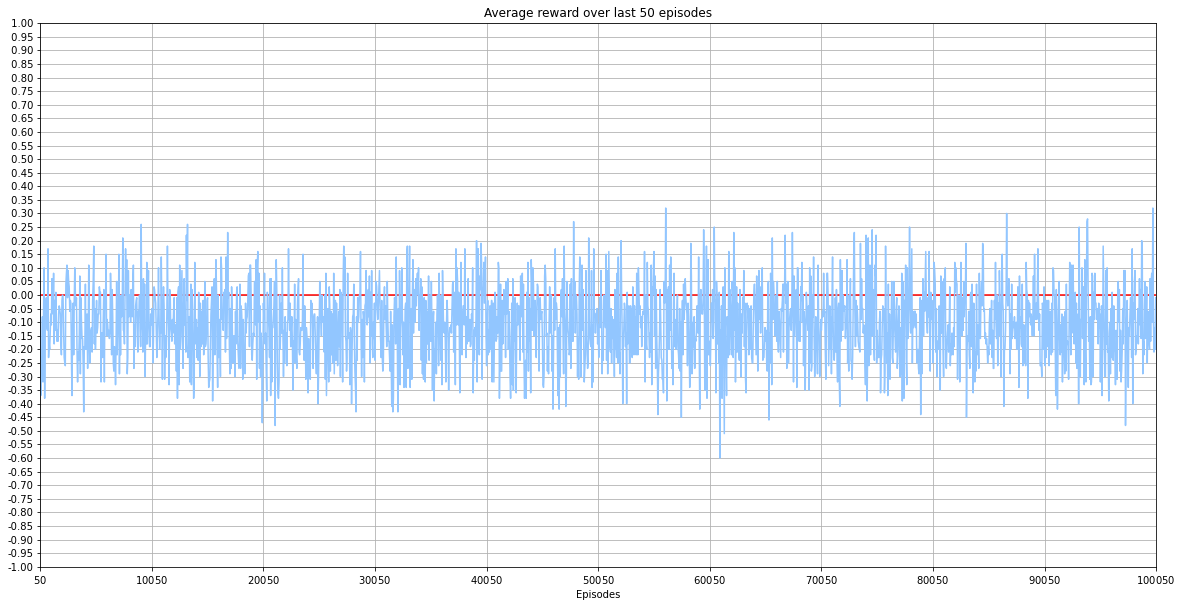

In [25]:
plot_reward_time_series(range(COLLECT_EVERY,EPISODES+1,COLLECT_EVERY),results);

In [26]:
runs = pd.Series(data=results, index=range(COLLECT_EVERY, EPISODES+1, COLLECT_EVERY))
runs.describe()

count    2000.000000
mean       -0.107040
std         0.138605
min        -0.600000
25%        -0.210000
50%        -0.100000
75%        -0.010000
max         0.320000
dtype: float64

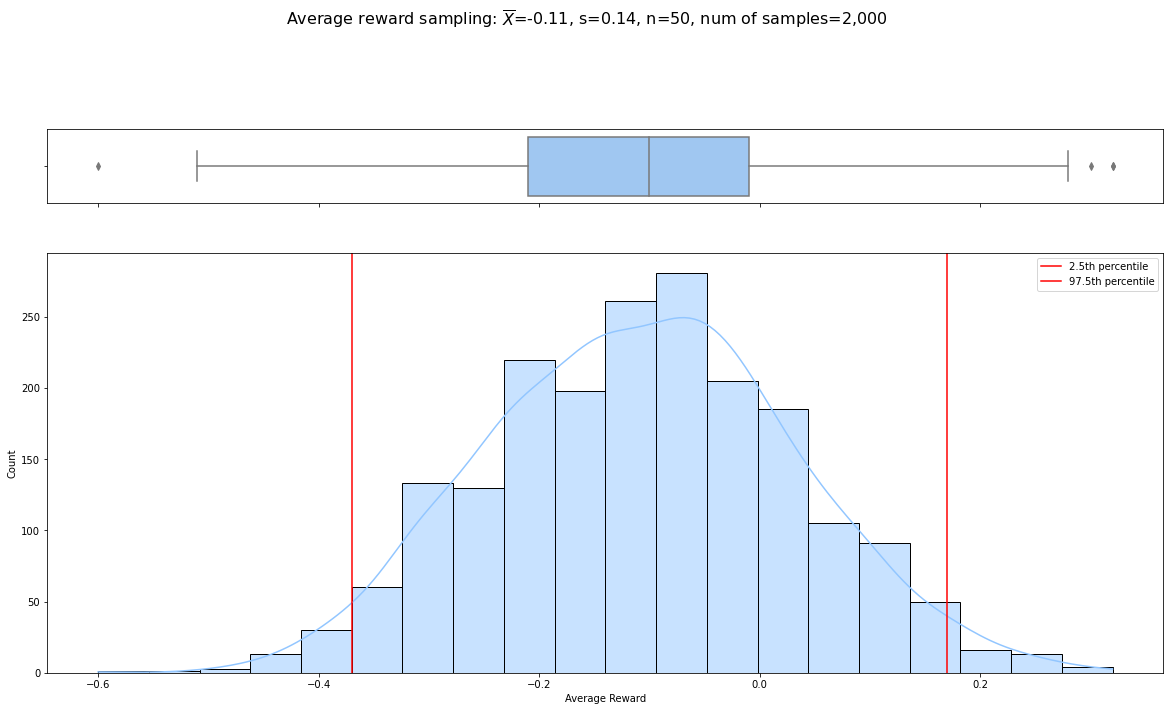

In [27]:
plot_density(runs);

It is necessary to extract the value function from the stochastic agent's q-table by calculating:

$$V(s) = \sum_{n=1}^{i}p(a_n|s)Q(s,a_n)$$ where **i** is the total number of allowed actions in a given state.

I translate that idea into a function:

In [28]:
def extract_v_func(agent, threshold, probs):
    """
    agent: RL agent instance
    threshold: int. The function only accepts one policy shift at a certain players' total value (the threshold).
    probs: 4-element tuple. The function only accepts two actions at every side of the threshold.
           index 0 = prob of taking action 1 at any state below the threshold
           index 1 = prob of taking action 2 at any state below the threshold
           index 2 = prob of taking action 1 at any state over the threshold
           index 3 = prob of taking action 2 at any state over the threshold
           
    returns: a V-table
    """
    table = agent.table.copy()
    #convert card value into matrix index:
    threshold = agent.table_look_up([threshold, 5, 1])[0]
    
    v_table_1 = table[:threshold,:,:,0] * probs[0] + table[:threshold,:,:,1] * probs[1]
    v_table_2 = table[threshold:,:,:,0] * probs[2] + table[threshold:,:,:,1] * probs[3]
    v_table = np.vstack((v_table_1, v_table_2))
    
    return v_table

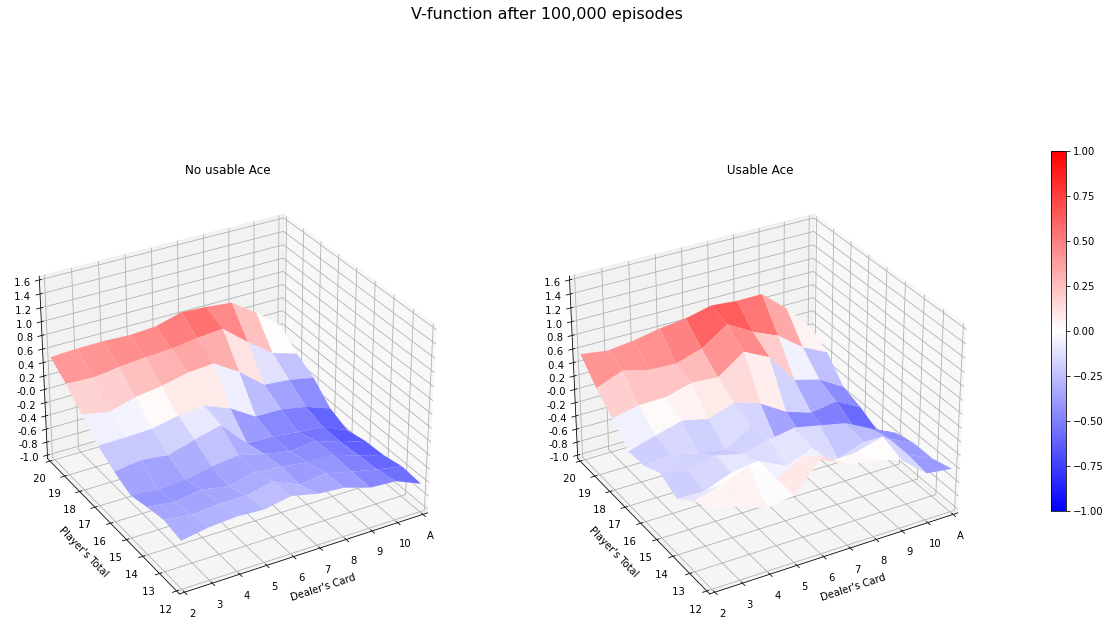

In [29]:
#function arguments according to the defined stochastic policy in the Stochastic class:
new_table = extract_v_func(stochastic_agent, 16, (0.1, 0.9, 0.9, 0.1))
plot_v_func(new_table, 'V-function after {:,.0f} episodes'.format(EPISODES));

#### **Third experiment: tracking value function evolution**

I bring to bear some persistence utilities to save V/Q-tables and track how their values evolve over the episodes. Moreover, it is worth remember that the ulterior goal is to save an agent capable of playing Blacjack and deploy it wherever it is needed.

In [30]:
#new agent instance:
persisted_agent = Stochastic(env)

In [31]:
EPISODES = 100_000
SHOW_EVERY = 10_000
#it is necessary to state how often one wants to save the V/Q-table by passing an integer to run_experiment method
SAVE_EVERY =  10_000
COLLECT_EVERY = 50
results = run_experiment(env, persisted_agent, EPISODES, SHOW_EVERY, SAVE_EVERY, COLLECT_EVERY)

Episode 10000:
Jack:
	-Cards: ['AC', '2D']
	-Value : 13
Dealer:
	-Cards: ['9D']
	-Value : 9
Jack decides to: HIT
	-Cards: ['AC', '2D', '10H']
	-Value : 13
Jack decides to: HIT
	-Cards: ['AC', '2D', '10H', '3D']
	-Value : 16
Jack decides to: STAND
	-Cards: ['AC', '2D', '10H', '3D']
	-Value : 16
Dealer:
	-Cards: ['9D', '7H', '2S']
	-Value : 18
THE HOUSE BEATS JACK
Episode 20000:
Jack:
	-Cards: ['7D', '8H']
	-Value : 15
Dealer:
	-Cards: ['6H']
	-Value : 6
Jack decides to: HIT
	-Cards: ['7D', '8H', '8S']
	-Value : 23
Dealer:
	-Cards: ['6H']
	-Value : 6
THE HOUSE BEATS JACK
Episode 30000:
Jack:
	-Cards: ['QS', 'JC']
	-Value : 20
Dealer:
	-Cards: ['8D']
	-Value : 8
Jack decides to: STAND
	-Cards: ['QS', 'JC']
	-Value : 20
Dealer:
	-Cards: ['8D', '3D', 'AH', '9H']
	-Value : 21
THE HOUSE BEATS JACK
Episode 40000:
Jack:
	-Cards: ['5D', '2S']
	-Value : 7
Dealer:
	-Cards: ['6S']
	-Value : 6
Jack decides to: HIT
	-Cards: ['5D', '2S', '4C']
	-Value : 11
Jack decides to: HIT
	-Cards: ['5D', '2S', '4

**Code note**: although the number of episodes to be executed has been explicitly stated, the agent computes a lesser amount of them since straight Blackjack episodes are not computed.

So how many episodes have been actually computed to update the Q-table?

In [32]:
persisted_agent.num_executed_episodes

95209

When has q-table been actually persisted?

In [33]:
persisted_agent.save_at_episodes

[9503, 19046, 28592, 38106, 47603, 57145, 66680, 76205, 85729, 95209]

Are Blackjack cases equally distributed?

In [34]:
list(map(lambda a, b: '{:.2%}'.format(1-(a/b)), persisted_agent.save_at_episodes, range(SAVE_EVERY, EPISODES+1, SAVE_EVERY)))

['4.97%',
 '4.77%',
 '4.69%',
 '4.74%',
 '4.79%',
 '4.76%',
 '4.74%',
 '4.74%',
 '4.75%',
 '4.79%']

It seems so!

Where are the tables stored?

In [35]:
persisted_agent.list_saved_tables()

['/home/xavi/Documents/Blackjack/tables/T_e1a4c1d846394306b760a841c9d463c4_9503',
 '/home/xavi/Documents/Blackjack/tables/T_e1a4c1d846394306b760a841c9d463c4_19046',
 '/home/xavi/Documents/Blackjack/tables/T_e1a4c1d846394306b760a841c9d463c4_28592',
 '/home/xavi/Documents/Blackjack/tables/T_e1a4c1d846394306b760a841c9d463c4_38106',
 '/home/xavi/Documents/Blackjack/tables/T_e1a4c1d846394306b760a841c9d463c4_47603',
 '/home/xavi/Documents/Blackjack/tables/T_e1a4c1d846394306b760a841c9d463c4_57145',
 '/home/xavi/Documents/Blackjack/tables/T_e1a4c1d846394306b760a841c9d463c4_66680',
 '/home/xavi/Documents/Blackjack/tables/T_e1a4c1d846394306b760a841c9d463c4_76205',
 '/home/xavi/Documents/Blackjack/tables/T_e1a4c1d846394306b760a841c9d463c4_85729',
 '/home/xavi/Documents/Blackjack/tables/T_e1a4c1d846394306b760a841c9d463c4_95209']

It is worth noting that every agent has a unique id and this is used to persist tables and ease their posterior retrieval:

In [36]:
persisted_agent.id

'e1a4c1d846394306b760a841c9d463c4'

Let's plot past tables chronologically and see how the values of the V-function evolve throught the whole experiment:

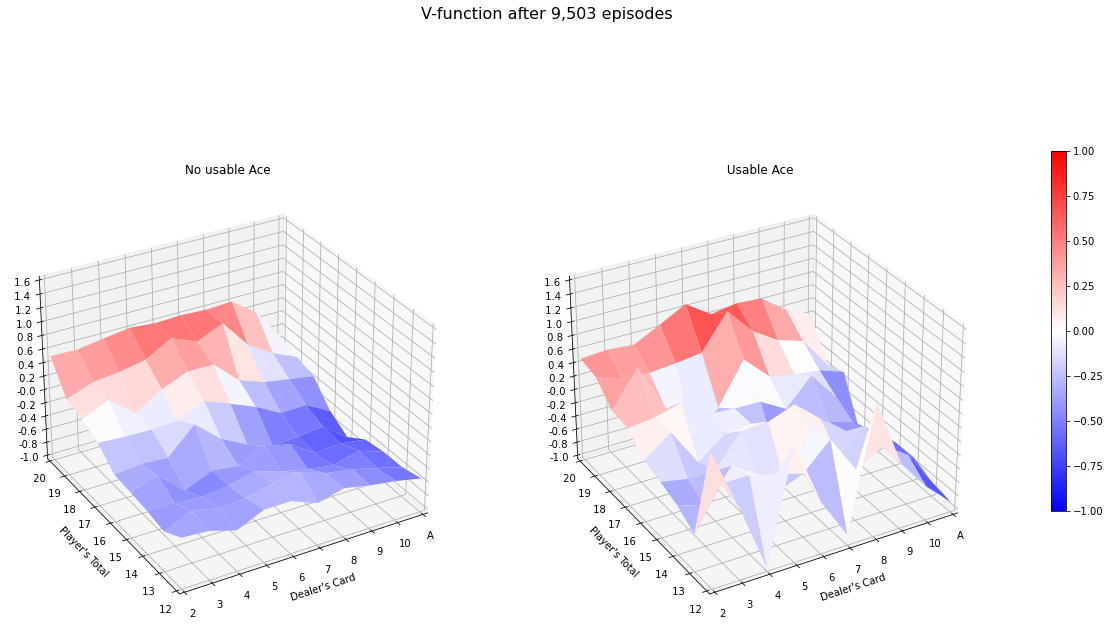

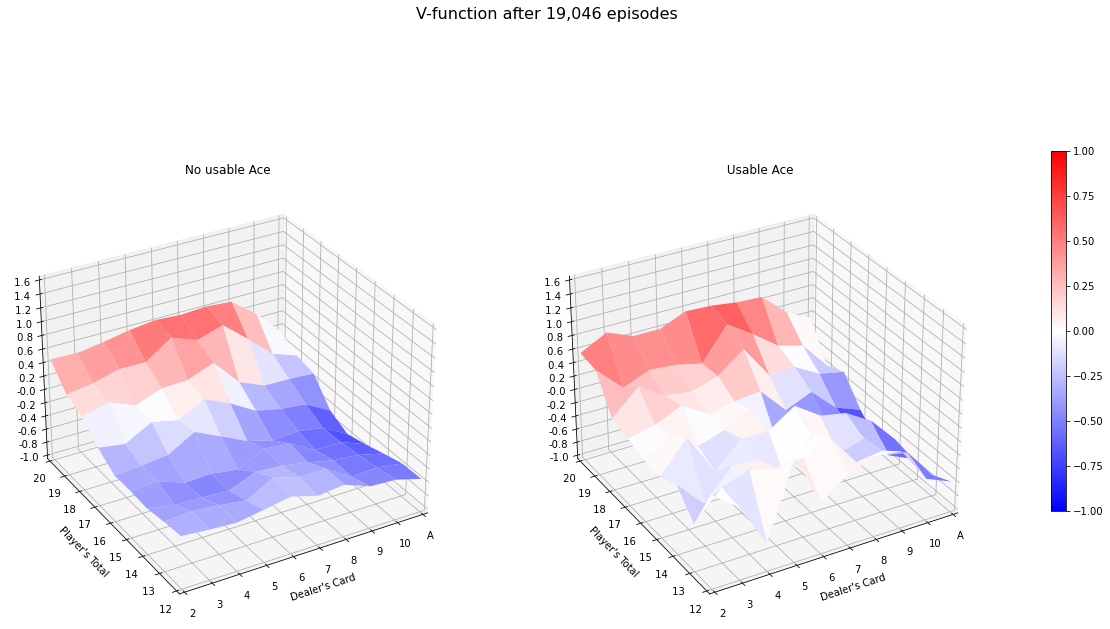

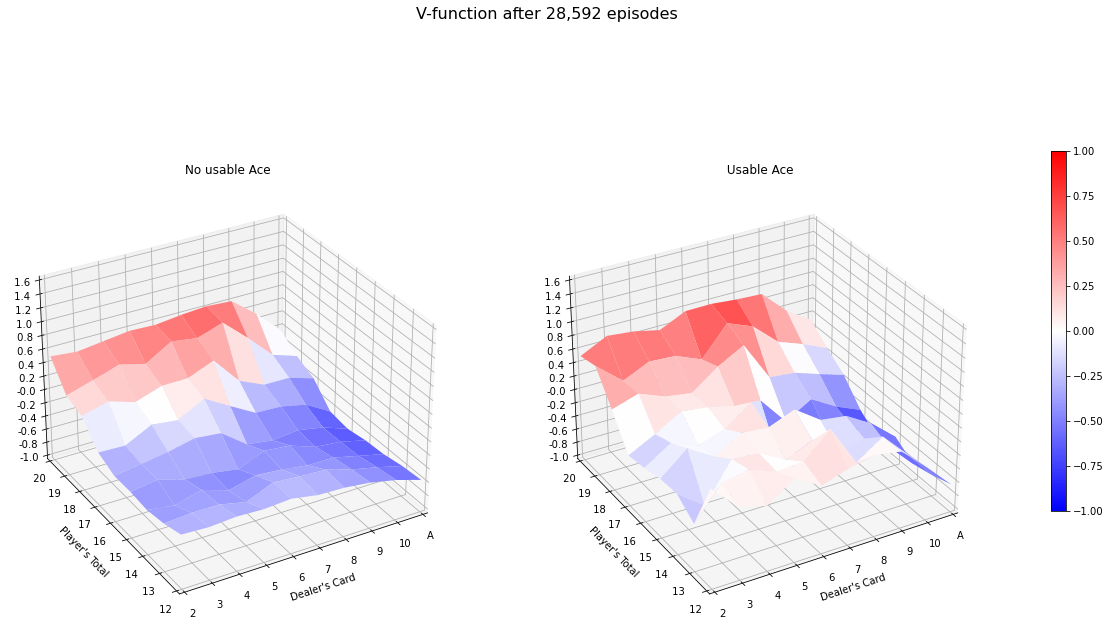

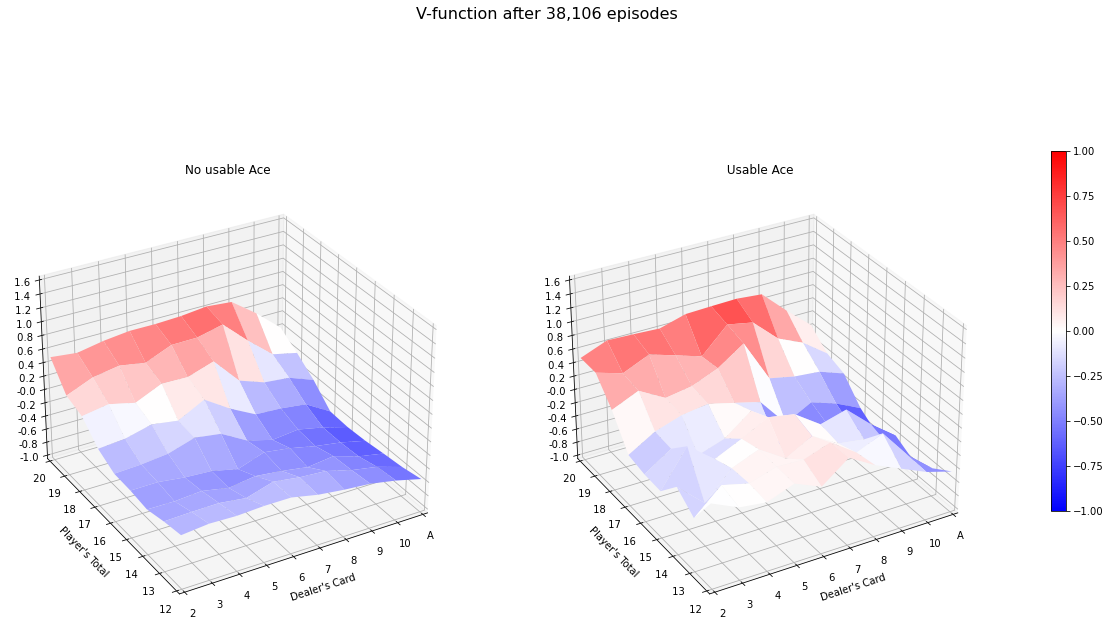

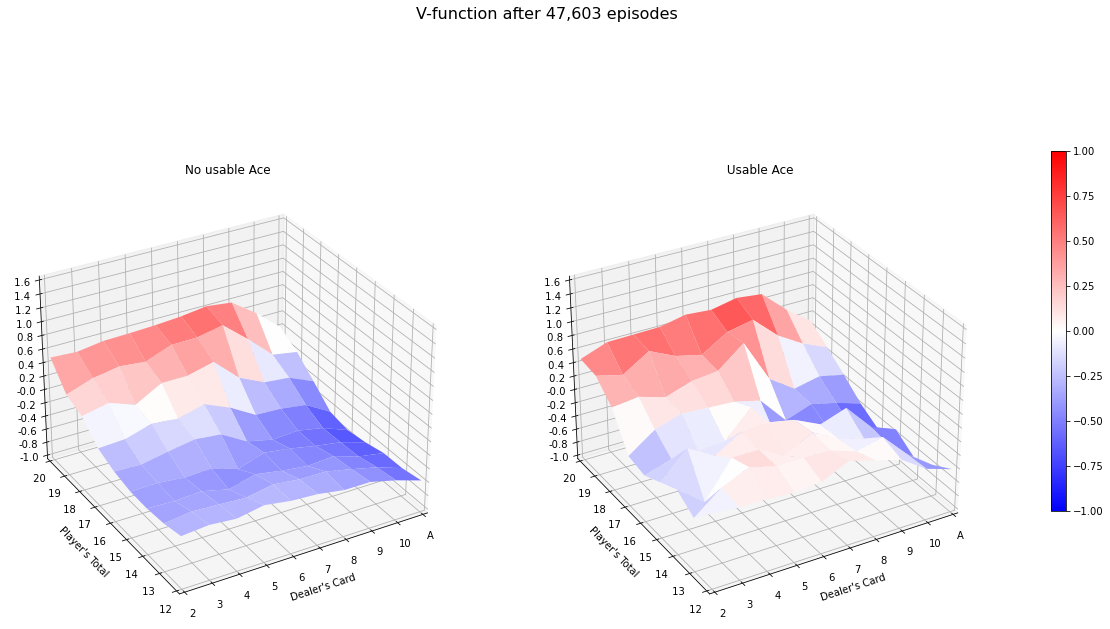

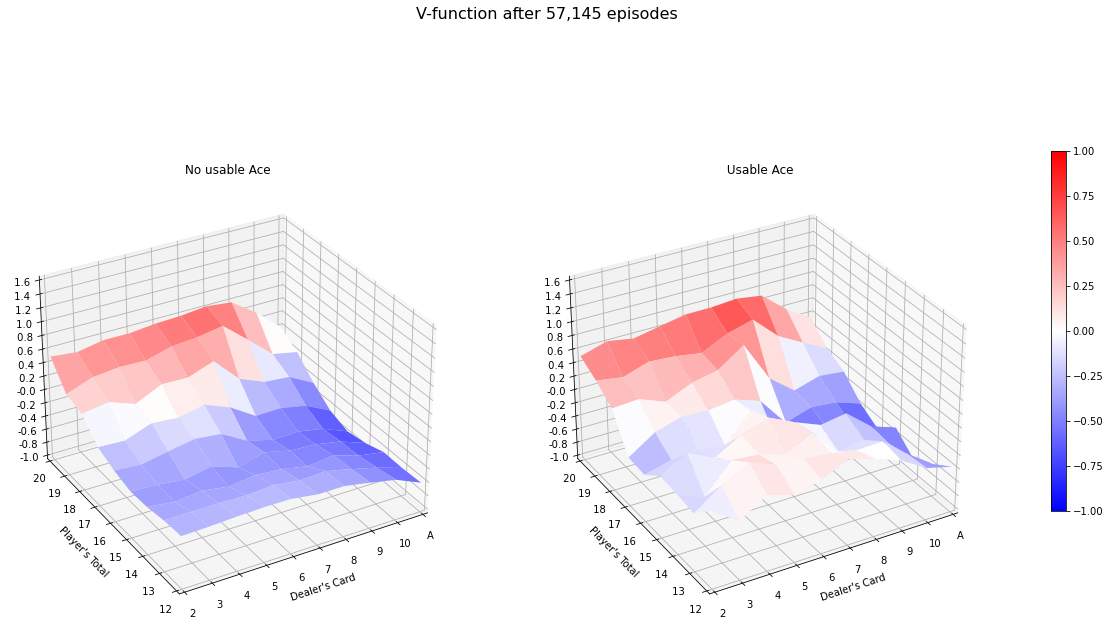

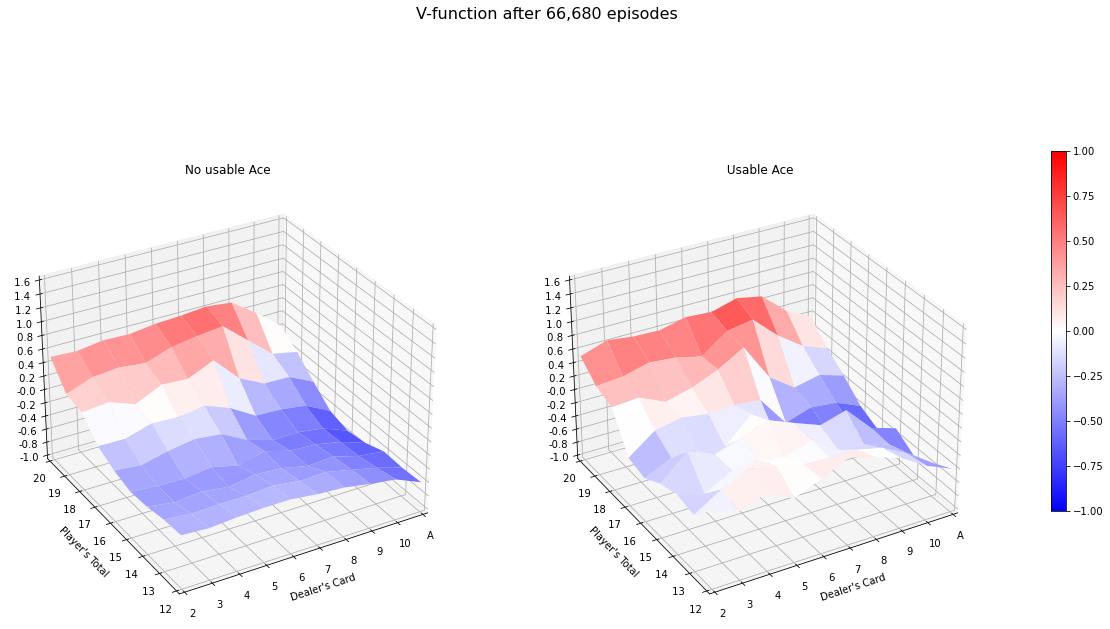

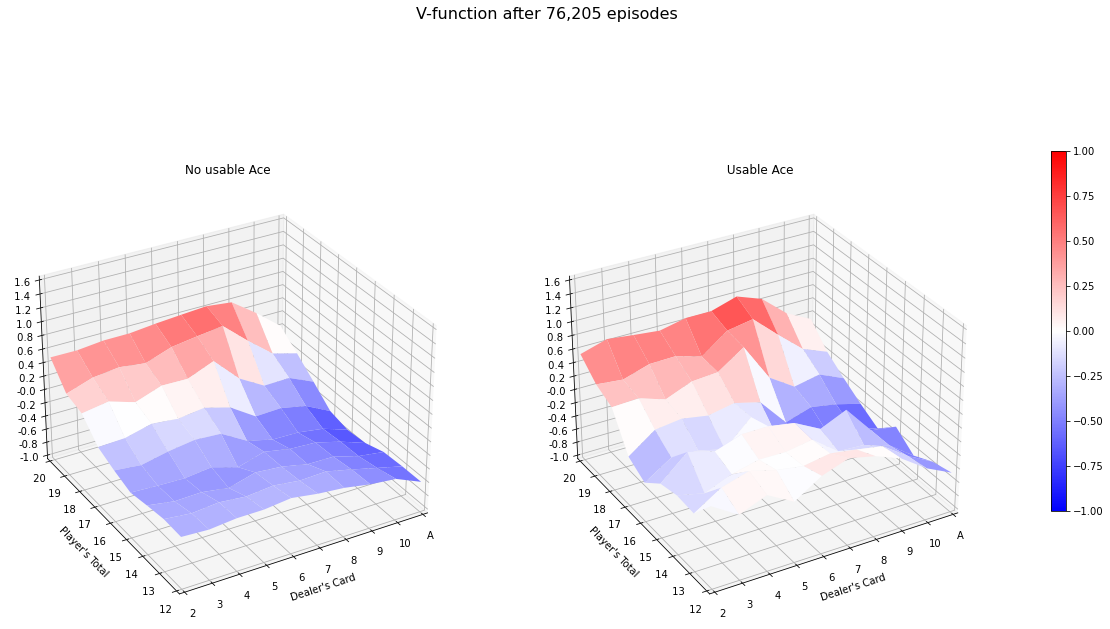

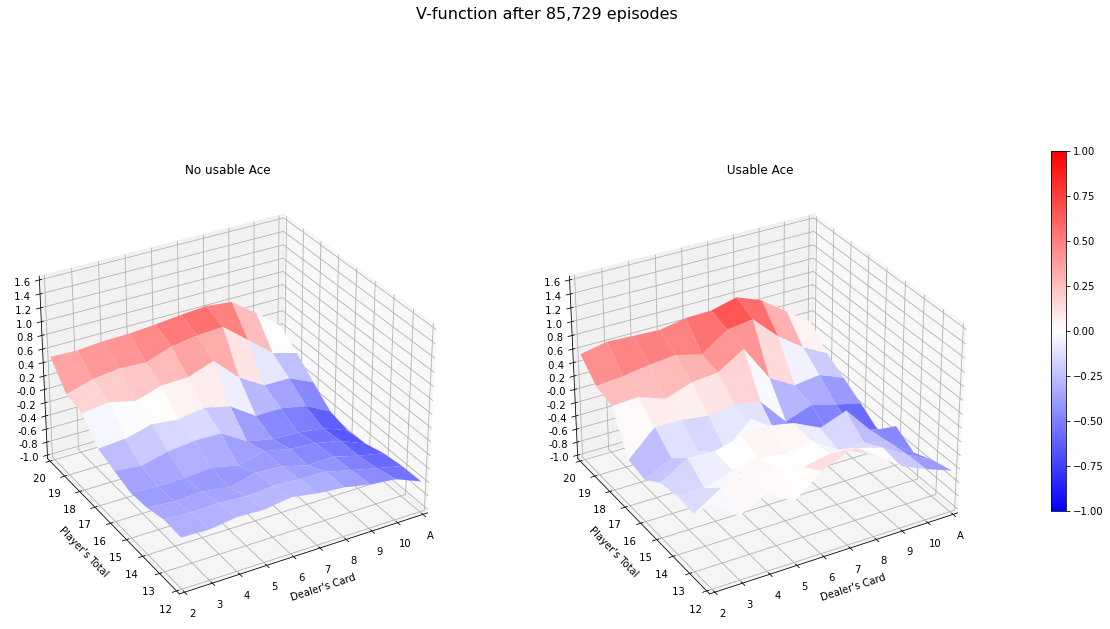

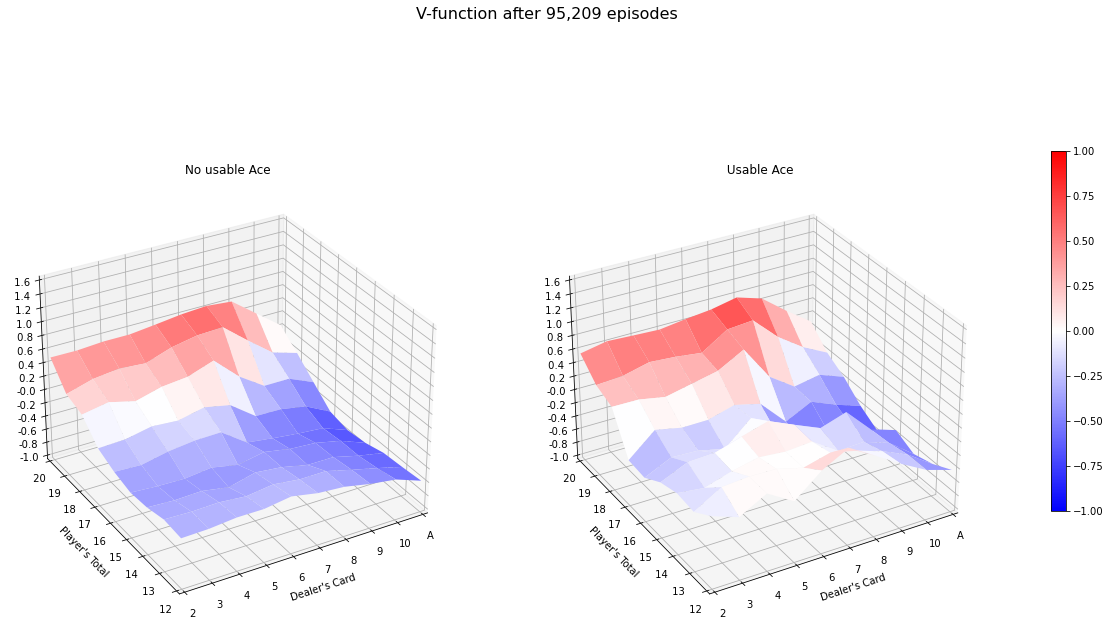

In [37]:
for file, episode in zip(persisted_agent.list_saved_tables(), persisted_agent.save_at_episodes):
    table = persisted_agent.load_table(filename=file, overwrite=True)
    v_table = extract_v_func(persisted_agent, 16, (0.1, 0.9, 0.9, 0.1))
    plot_v_func(v_table, 'V-function after {:,.0f} episodes'.format(episode))

### 2. Montecarlo Control:

The agent computes the expected return for each state-action pair as if it was a MonteCarloPredictor. It greedily acts when it comes to deciding which action to take at every state. However, exploration is encouraged by allowing the agent to use apparently worse actions in $\epsilon$/2 % of the total time steps.

The algorithm is as follows:
<img src='interfaces/web/static/img/Montecarlo_Control.png'>

Soft policy means that all actions in all states must have nonzero probability.

In [38]:
#Instead of subclassing MonteCarloPredictor, I use MonteCarloController:
class Control(MontecarloController):

    def follow_policy(self, observation, *args):
        table_look_up = tuple(self.table_look_up(observation))
        #Enforcing continuous exploration.
        #I will discuss how to make sure that agent behaves greedily in the limit with infinite exploration in a later notebook.
        max_action = np.argmax(self.table[table_look_up][:])
        #there are just two action, so that the formula can be simplified:
        probs = np.ones(self.environment.action_space_len) * self.hyperparams['epsilon_min']/self.environment.action_space_len
        probs[max_action] = 1 - self.hyperparams['epsilon_min']/self.environment.action_space_len
        
        return np.random.choice(self.environment.action_space_len, p=probs)

In [39]:
controller = Control(env)

It is worth noting that the agent already possesses default values to deal with exploration:

In [40]:
controller.hyperparams

{'discount_rate': 1,
 'learning_rate': None,
 'max_episodes': None,
 'epsilon_start': 1,
 'epsilon_min': 0.05,
 'epsilon_decay': 0.995,
 'ucb_c': 1}

Let's attempt to learn:

In [41]:
# I execute a larger experiment than the previous ones
EPISODES = 200_000
SHOW_EVERY = 100_000
SAVE_EVERY =  None
COLLECT_EVERY = 5_000
results = run_experiment(env, controller, EPISODES, SHOW_EVERY, SAVE_EVERY, COLLECT_EVERY)

Episode 100000:
Jack:
	-Cards: ['2S', '8C']
	-Value : 10
Dealer:
	-Cards: ['2D']
	-Value : 2
Jack decides to: STAND
	-Cards: ['2S', '8C']
	-Value : 10
Dealer:
	-Cards: ['2D', 'AC', '3H', '7C', 'KC']
	-Value : 23
JACK BEATS THE HOUSE
Episode 200000:
Jack:
	-Cards: ['3D', '3C']
	-Value : 6
Dealer:
	-Cards: ['5D']
	-Value : 5
Jack decides to: HIT
	-Cards: ['3D', '3C', 'AD']
	-Value : 17
Jack decides to: STAND
	-Cards: ['3D', '3C', 'AD']
	-Value : 17
Dealer:
	-Cards: ['5D', '8D', 'AH', '4D']
	-Value : 18
THE HOUSE BEATS JACK


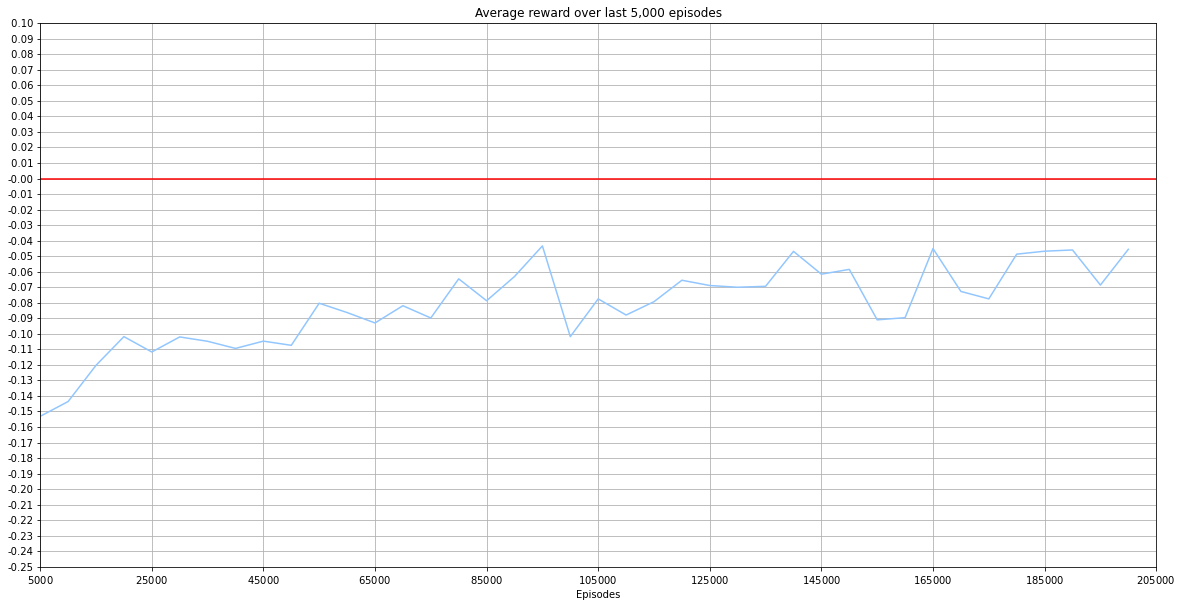

In [42]:
plot_reward_time_series(range(COLLECT_EVERY, EPISODES+1, COLLECT_EVERY),results, far=False);

A slighlty upward trend is observed in the plot above and can be buttressed by printing the first, halfway-through and last observations:

In [43]:
results[0], results[19], results[-1]

(-0.1531, -0.1018, -0.0456)

Let's extract the V-function by applying the following relation between Bellman Equations:

$$V(s)=\underset{a}{\operatorname{\arg\max}}Q(s,a)$$

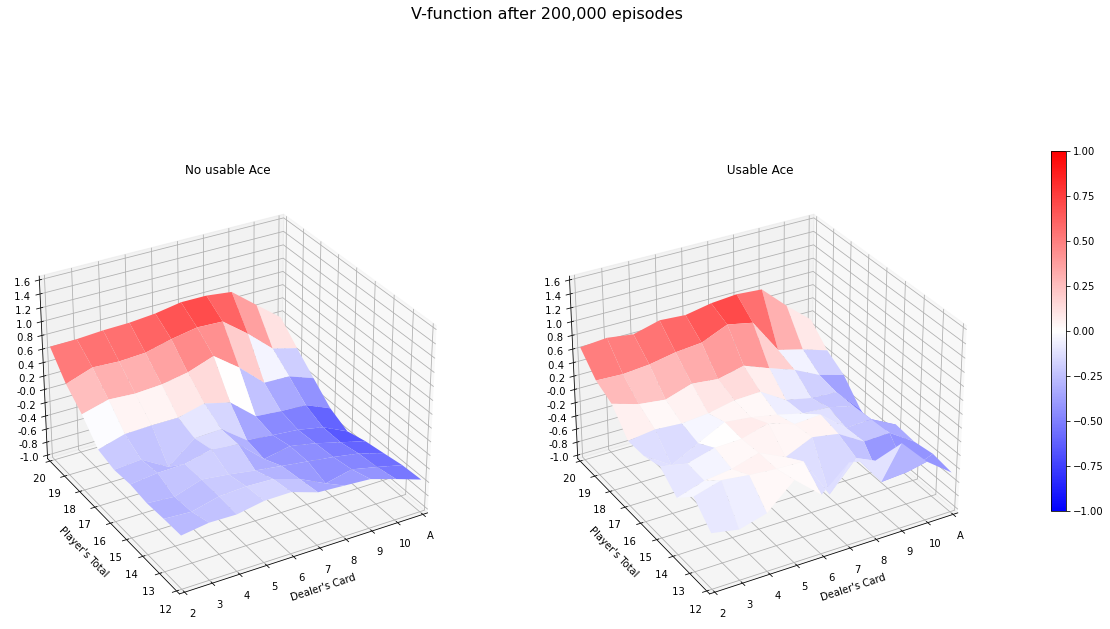

In [44]:
plot_v_func(np.amax(controller.table, axis=3), 'V-function after {:,.0f} episodes'.format(EPISODES));

What policy does the agent end up using when the experiment ends?

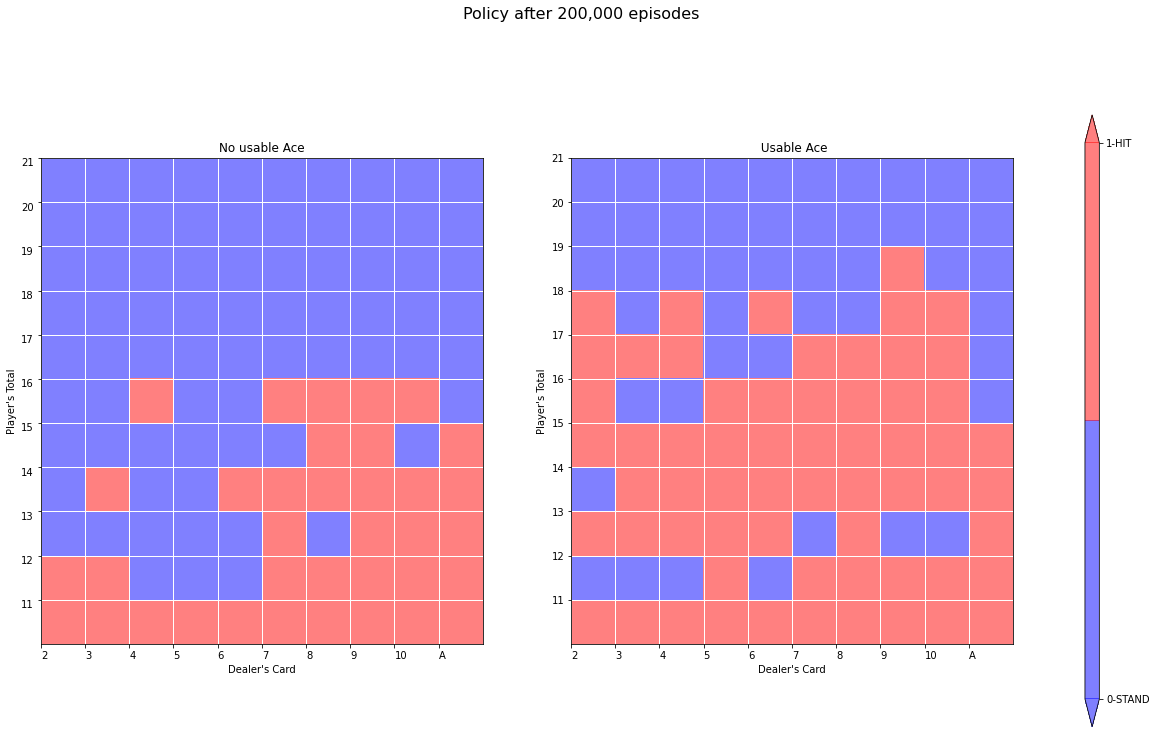

In [45]:
#it is first necessary to extract the policy from the q-table:
policy_table = np.argmax(controller.table, axis=3)
plot_policy(policy_table, 'Policy after {:,.0f} episodes'.format(EPISODES));

### 3. Off-policy Montecarlo:

Off-policy methods make use of two different policies: the behaviour policy that it is used to interact with the environment and the target policy, the one to be evaluated and improved. The former can be stochastic in pursuit of exploring all possible actions and the latter should be greedily deterministic, making the most out of the exploring effort.

The algorithm is as follows:

<img src='interfaces/web/static/img/Off_Policy_Montecarlo.png'>

It incrementally implements weighted importance sampling. It pushes the Q-value to its true value by the relative probability of the trajectory under the target and the behaviour policy (how often the state-action pair is visited under the target policy/how often the state action pair is visited under the behaviour policiy. So:

$C(S_t, A_t)$ is the cumulative weight of a state-action pair over the whole experiment (a sort of weight time step counter); 

If greedy and stochastic actions do not match in a given state, the updating process is interrupted. This could slow learning if non-greedy actions are frequently chosen.on

The weighing is based on the how near the state-action is from the terminal state.

In [46]:
class OffPolicyMC(OffPolicyMontecarlo):
    #Extreme case: always play randomly:
    def follow_policy(self, observation, *args):
        return np.random.choice((0,1))

In [47]:
off_policy = OffPolicyMC(env)

In [48]:
off_policy.hyperparams

{'discount_rate': 1,
 'learning_rate': None,
 'max_episodes': None,
 'epsilon_start': 1,
 'epsilon_min': 0.05,
 'epsilon_decay': 0.995,
 'ucb_c': 1}

In [49]:
EPISODES = 500_000
SHOW_EVERY = 100_000
SAVE_EVERY =  None
COLLECT_EVERY = 10_000
results = run_experiment(env, off_policy, EPISODES, SHOW_EVERY, SAVE_EVERY, COLLECT_EVERY)

Episode 100000:
Jack:
	-Cards: ['QS', 'QC']
	-Value : 20
Dealer:
	-Cards: ['5H']
	-Value : 5
Jack decides to: STAND
	-Cards: ['QS', 'QC']
	-Value : 20
Dealer:
	-Cards: ['5H', '6S', 'JC']
	-Value : 21
THE HOUSE BEATS JACK
Episode 200000:
Jack:
	-Cards: ['AH', '2D']
	-Value : 13
Dealer:
	-Cards: ['QS']
	-Value : 10
Jack decides to: STAND
	-Cards: ['AH', '2D']
	-Value : 13
Dealer:
	-Cards: ['QS', '5D', 'QD']
	-Value : 25
JACK BEATS THE HOUSE
Episode 300000:
Jack:
	-Cards: ['2S', '6S']
	-Value : 8
Dealer:
	-Cards: ['10S']
	-Value : 10
Jack decides to: HIT
	-Cards: ['2S', '6S', '5S']
	-Value : 13
Jack decides to: HIT
	-Cards: ['2S', '6S', '5S', '2C']
	-Value : 15
Jack decides to: STAND
	-Cards: ['2S', '6S', '5S', '2C']
	-Value : 15
Dealer:
	-Cards: ['10S', '8S']
	-Value : 18
THE HOUSE BEATS JACK
Episode 400000:
Jack:
	-Cards: ['6S', '10S']
	-Value : 16
Dealer:
	-Cards: ['JC']
	-Value : 10
Jack decides to: STAND
	-Cards: ['6S', '10S']
	-Value : 16
Dealer:
	-Cards: ['JC', '9S']
	-Value : 19
T

Let's plot how the random policy fares:

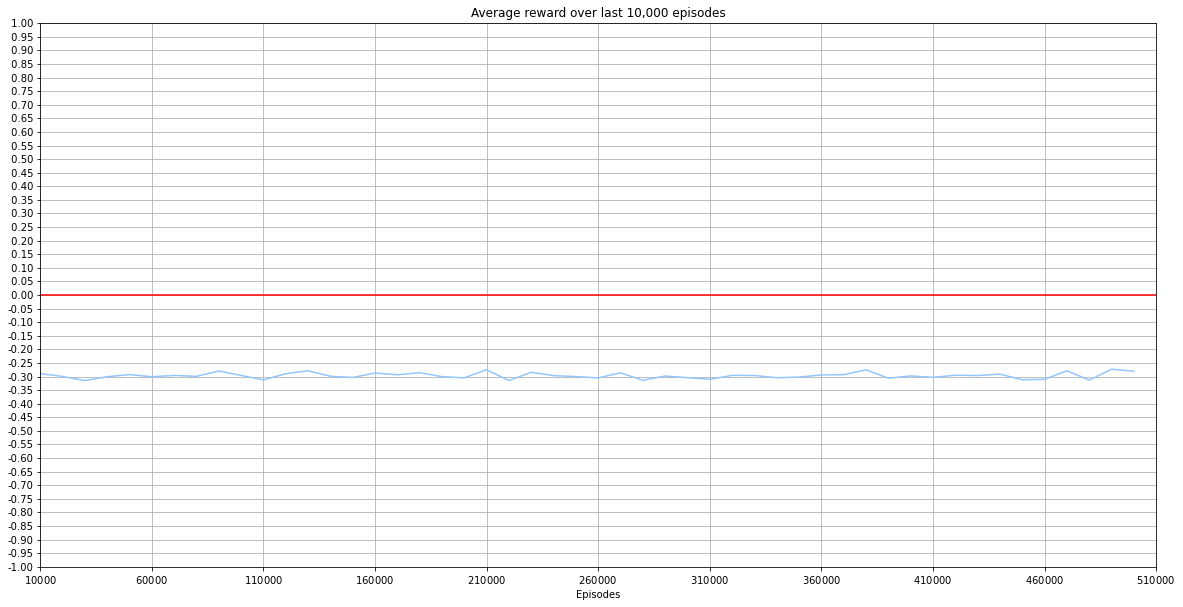

In [50]:
plot_reward_time_series(range(COLLECT_EVERY, EPISODES+1, COLLECT_EVERY),results);

In [51]:
runs = pd.Series(data=results, index=range(COLLECT_EVERY, EPISODES+1, COLLECT_EVERY))
runs.describe()

count    50.000000
mean     -0.296593
std       0.010980
min      -0.314850
25%      -0.303913
50%      -0.297250
75%      -0.290075
max      -0.273150
dtype: float64

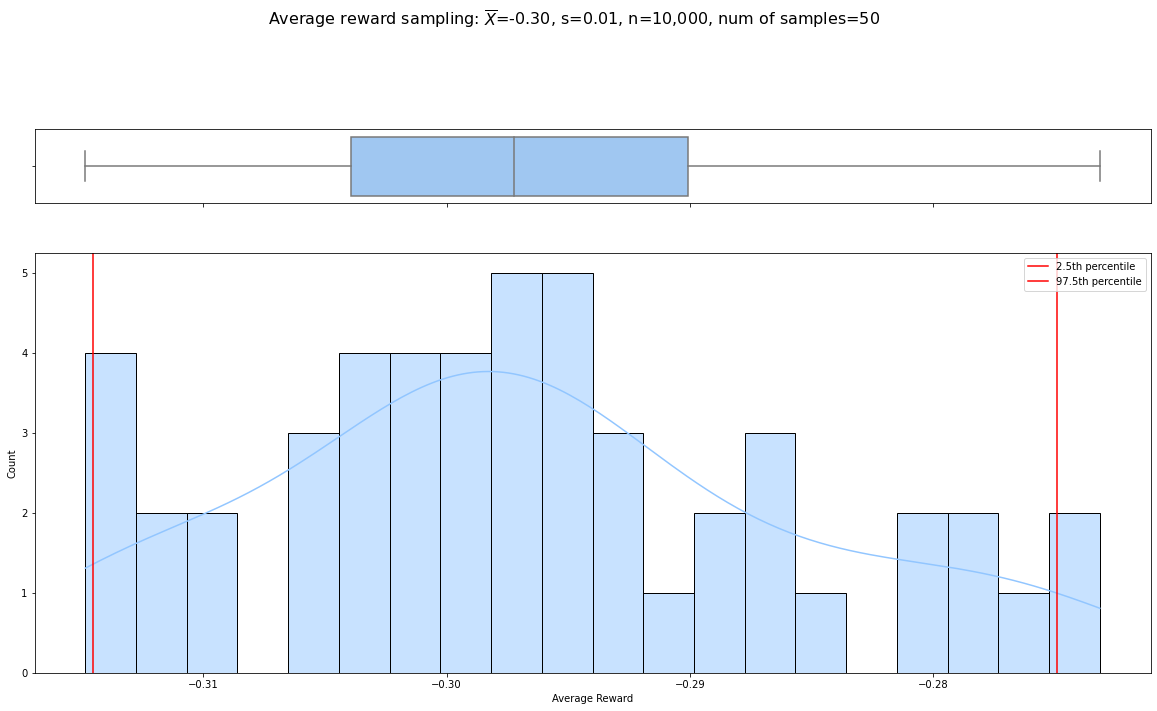

In [52]:
plot_density(runs);

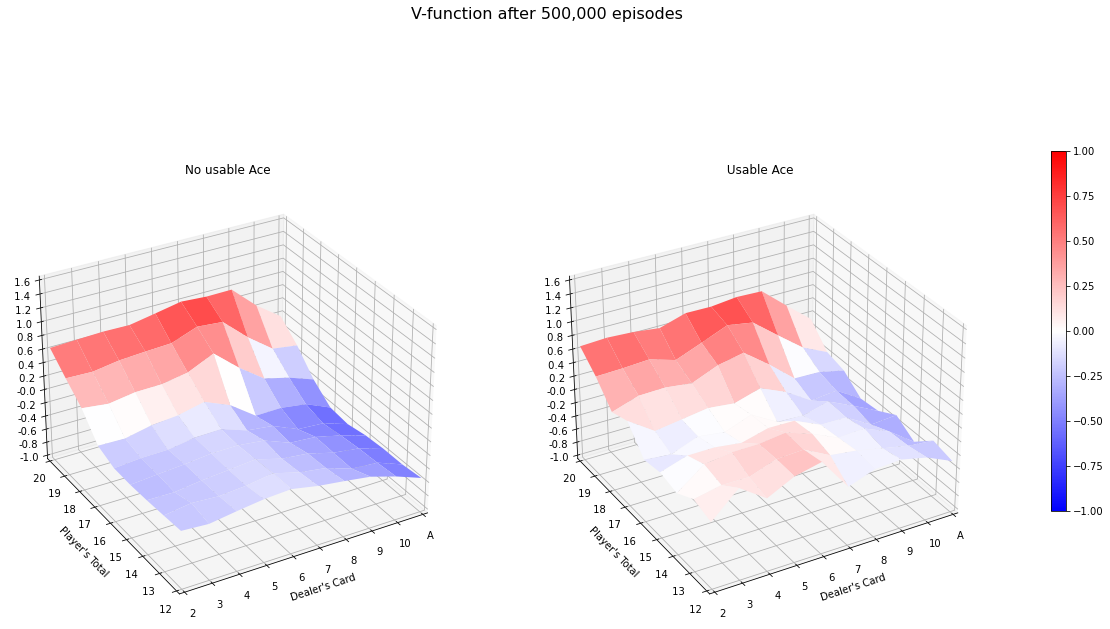

In [53]:
plot_v_func(np.amax(off_policy.table, axis=3), 'V-function after {:,.0f} episodes'.format(EPISODES));

Let's plot the deterministic policy derived from the off-policy algorithm:

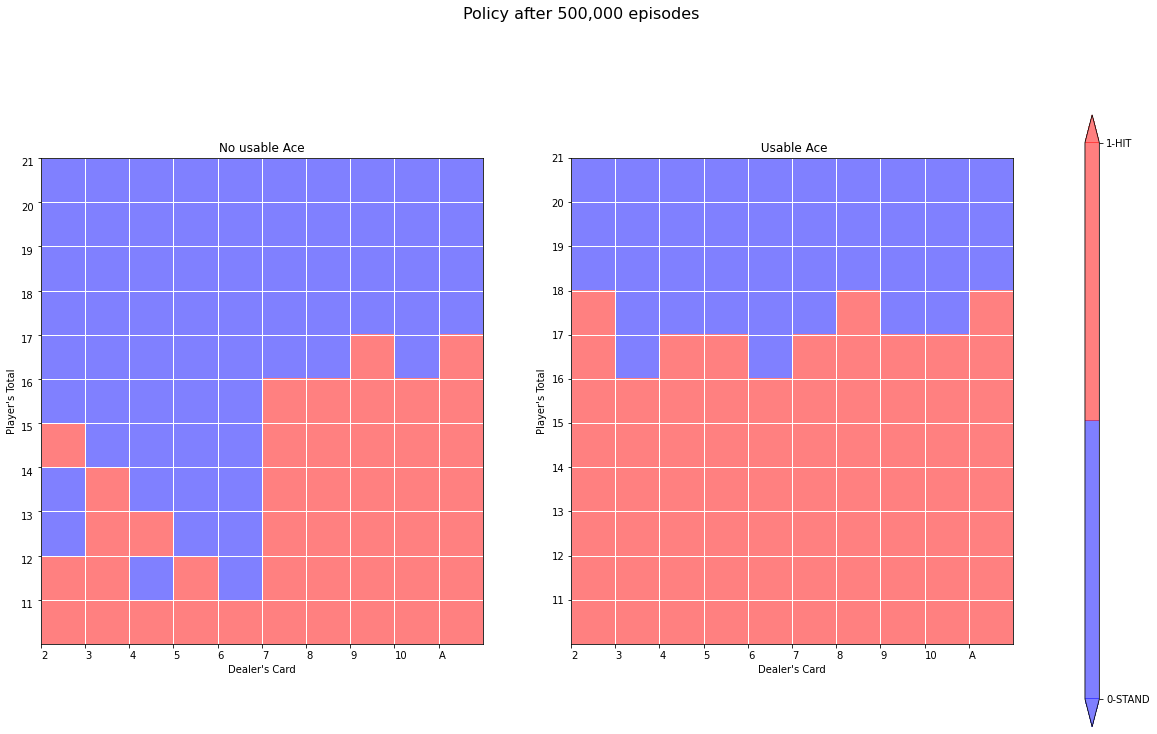

In [54]:
policy_table = np.argmax(off_policy.table, axis=3)
plot_policy(policy_table, 'Policy after {:,.0f} episodes'.format(EPISODES));

However, we need to assess what the expected return under the greedy policy is. To do so, let's execute that policy throughtout the same number of episodes.

In [55]:
class Greedy(MonteCarloPredictor):

    def follow_policy(self, observation, *args):
        table_look_up = tuple(self.table_look_up(observation))
        action = np.argmax(self.table[table_look_up][:])
        return action

In [56]:
evaluator = Greedy(env)
# I transfer the Q-table to the new agent
evaluator.table = off_policy.table.copy()
#The train parameter is set to False to prevent the agent from updating its Q-table:
results = run_experiment(env, evaluator, EPISODES, SHOW_EVERY, SAVE_EVERY, COLLECT_EVERY,train=False)

Episode 100000:
Jack:
	-Cards: ['AH', 'AC']
	-Value : 12
Dealer:
	-Cards: ['10S']
	-Value : 10
Jack decides to: HIT
	-Cards: ['AH', 'AC', '5H']
	-Value : 17
Jack decides to: HIT
	-Cards: ['AH', 'AC', '5H', '3S']
	-Value : 20
Jack decides to: STAND
	-Cards: ['AH', 'AC', '5H', '3S']
	-Value : 20
Dealer:
	-Cards: ['10S', 'AD']
	-Value : 21
THE HOUSE BEATS JACK
Episode 200000:
Jack:
	-Cards: ['3H', 'KH']
	-Value : 13
Dealer:
	-Cards: ['AC']
	-Value : 11
Jack decides to: HIT
	-Cards: ['3H', 'KH', 'QC']
	-Value : 23
Dealer:
	-Cards: ['AC']
	-Value : 11
THE HOUSE BEATS JACK
Episode 300000:
Jack:
	-Cards: ['9C', '9C']
	-Value : 18
Dealer:
	-Cards: ['3S']
	-Value : 3
Jack decides to: STAND
	-Cards: ['9C', '9C']
	-Value : 18
Dealer:
	-Cards: ['3S', '9D', '8S']
	-Value : 20
THE HOUSE BEATS JACK
Episode 400000:
Jack:
	-Cards: ['6D', '2S']
	-Value : 8
Dealer:
	-Cards: ['10S']
	-Value : 10
Jack decides to: HIT
	-Cards: ['6D', '2S', '8C']
	-Value : 16
Jack decides to: HIT
	-Cards: ['6D', '2S', '8C', 

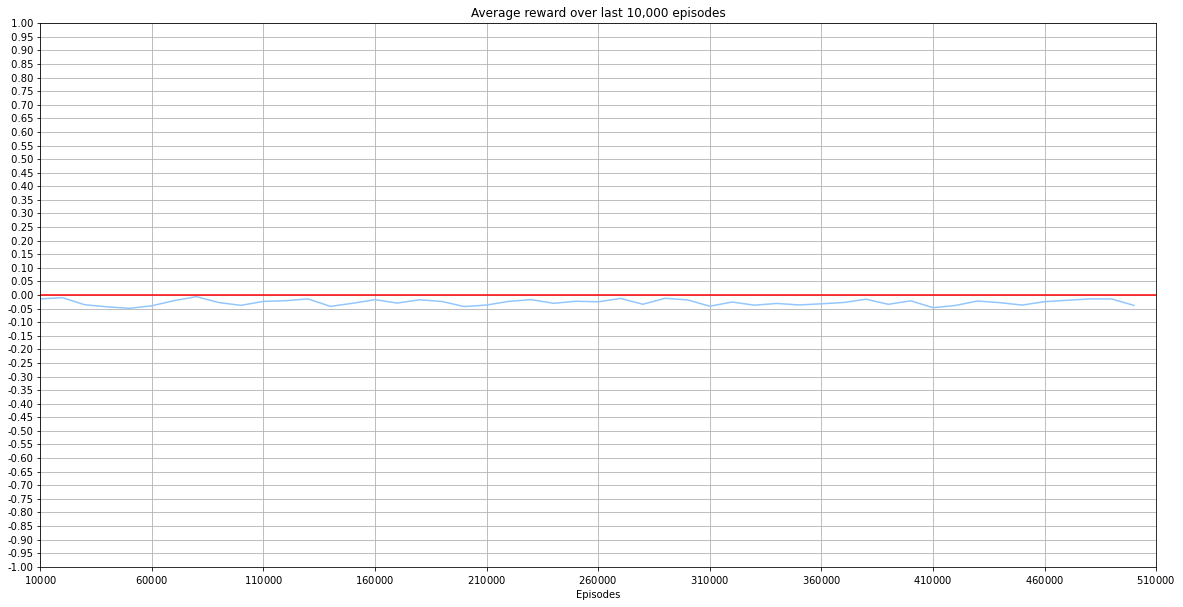

In [57]:
plot_reward_time_series(range(COLLECT_EVERY, EPISODES+1, COLLECT_EVERY),results);

In [58]:
runs = pd.Series(data=results, index=range(COLLECT_EVERY, EPISODES+1, COLLECT_EVERY))
runs.describe()

count    50.000000
mean     -0.027332
std       0.010652
min      -0.049000
25%      -0.036850
50%      -0.026700
75%      -0.018375
max      -0.006050
dtype: float64

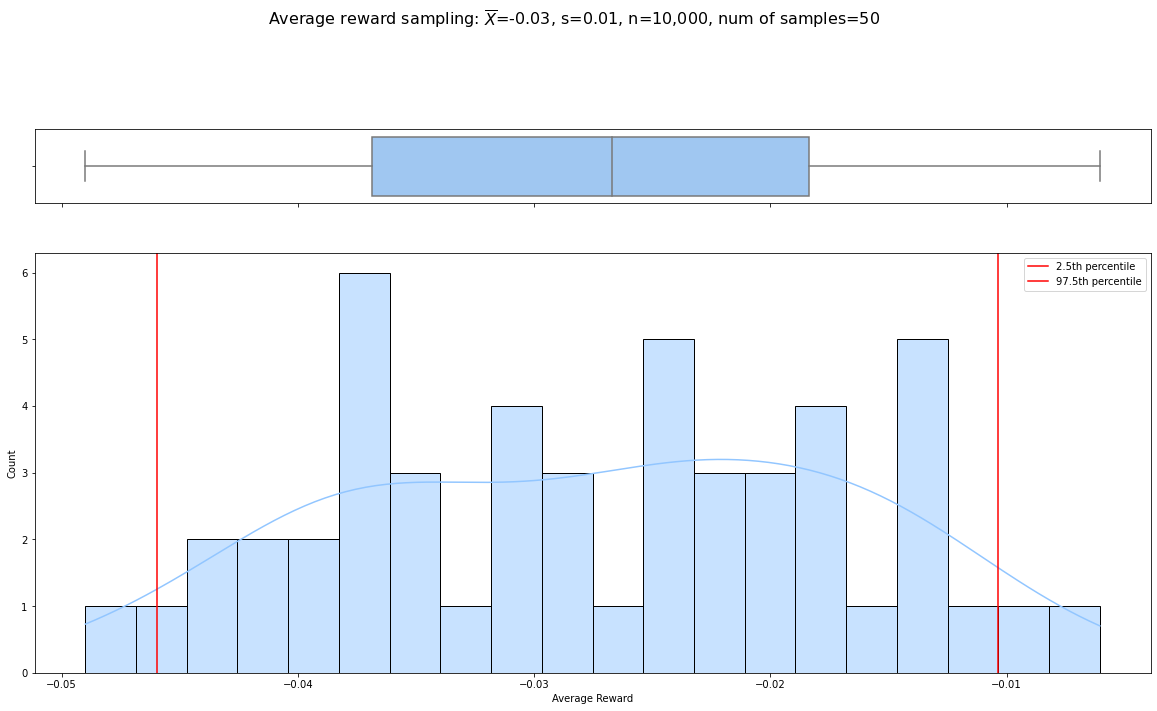

In [59]:
plot_density(runs);